# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**: Fenya Bartram

**ID**: fdb34

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [81]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\fenya\Documents\BEE4750\hw3-bottom-stimulating-reflectors`


In [82]:
using Plots.PlotMeasures

In [83]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames
using Plots.PlotMeasures

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

Solutions




The code has two functions, one to carry out mixing calculations and another to calculate concentrations of DO, CBOD, and NBOD downstream based on the plug-flow reactor model, assuming constant radial mixing, and applying a mass balance, neglecting photosynthesis, respiration, and benthal uptake (derived in class).




Mixing equation:
$$
\begin{align*}
C_{mixed} = \frac{C_{river}*Q_{river}+C_{waste}*Q_{waste}}{Q_{river}+Q_{waste}}
\end{align*}
$$




$$
\begin{align*}
Q_{total} = Q_{river} + Q_{waste}
\end{align*}
$$


where C is the concentration in the river or waste steam, and Q is volumetric flow rate of these. These equations apply for concentrations of DO, CBOD and NBOD.




Exponential decay of CBOD and NBOD and Streeter-Phelps equation:




$$
\begin{align*}
B(x) = B_{0}exp(- \frac{k_{c}x}{U}) \\
N(x) = N_{0}exp(- \frac{k_{n}x}{U}) \\
C(x) = C_{s}(1-\alpha_{1})+C_{0}\alpha_{1}-B_{0}\alpha_{2}- N_{0}\alpha_{3}\\
\alpha_{1} = exp(- \frac{k_{a}x}{U}) \\
\alpha_{2} = (\frac{k_{c}}{k_{a}-k_{c}})[exp(- \frac{k_{c}x}{U})-exp(- \frac{k_{a}x}{U})] \\
\alpha_{3} = (\frac{k_{n}}{k_{a}-k_{n}})[exp(- \frac{k_{n}x}{U})-exp(- \frac{k_{a}x}{U})] \\
\end{align*}
$$




Where U is the speed, $k_{c}$, $k_{n}$, and $k_{a}$ are the decay constants for CBOD and NBOD and the reaeration constant respectively, x is the downstream distance, and B, N and C are the concentrations of and CBOD, NBOD, and DO respectively.




The mixing function is used to calculate the initial conditions, which are entered into the simulation function. This is used to run the simulation up to 15 meters. The results for 15 meters are then used as input into another mixing calculation, along with the parameters for waste stream 2, producing the concentrations after the 2nd mixing. These are used as initial conditions in a second simulation, from 0 to 35(50-15) meters after this mixing. Finally, the results are plotted as a function of the distance downstream. The minimum value is 3.757 mg/L, occurring 24 km downriver.




By trial and error, about 15.0% removal of organic waste from waste stream 1 will prevent the oxygen from dropping below 4 mg/L. For stream 2, about 11.7% removal will be required.




In order to decide which stream(s) to treat, I would need to know about the relative costs of treating each stream. Depending on the type, one might be more difficult or costly to clean than the other, in which case I would treat the less costly option. Another factor would be if there are other pollutants of concern in one or both of the waste streams which might require them to be treated.

















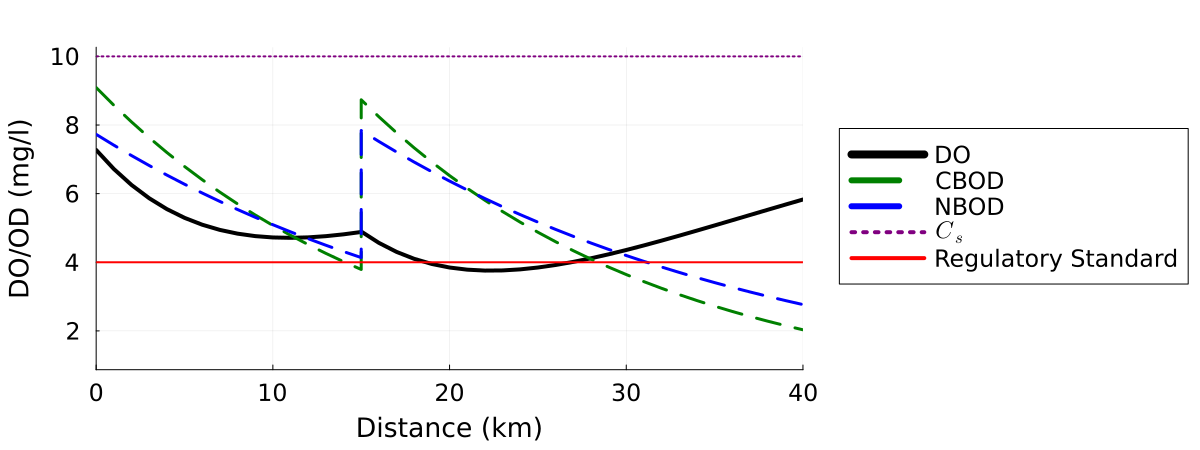

In [89]:
# set river properties
ka = 0.55
kc = 0.35
kn = 0.25

Qr = 100000
Cr = 7.5
Br = 5
Nr = 5

Q1 = 10000
C1 = 5
B1 = 50
N1 = 35

Q2 = 15000
C2 = 5
B2 = 45
N2 = 35

# C0 = 6.2
# B0 = 9
# N0 = 7

Cs = 10
U = 6

function do_simulate(x, C0, B0, N0, ka, kc, kn, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N)
end  

function do_mixing(Q1, Q2, C1, C2, B1, B2, N1, N2)
    Q = Q1 + Q2
    C = (C1*Q1+C2*Q2)/Q
    B = (B1*Q1+B2*Q2)/Q
    N = (N1*Q1+N2*Q2)/Q
    return (Q,C,B,N)
end 

# Q0, C0, B0, N0 = do_mixing(Q1, Q2, C1, C2)




Q0, C0, B0, N0 = do_mixing(Qr, Q1, Cr, C1, Br, B1, Nr, N1)
x = vcat(0:15, 15:50)

# evaluate model over all x's
# this uses broadcasting
do_out = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(0:15)
Cr2, Br2, Nr2 = do_out[16]
Q0, C0, B0, N0 = do_mixing(Q0, Q2, Cr2, C2, Br2, B2, Nr2, N2)
do_out2 = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(0:50-15)

# unpack outputs into individual arrays for C, B, and N
# this uses comprehensions to pull out the relevant components 
#of the tuples that our function outputs
C = vcat([d[1] for d in do_out], [d[1] for d in do_out2])
B = vcat([d[2] for d in do_out], [d[2] for d in do_out2])
N = vcat([d[3] for d in do_out], [d[3] for d in do_out2])
# plot outputs
p1 = plot(; ylabel="DO/OD (mg/l)", xlabel="Distance (km)", left_margin=8mm, top_margin=10mm, guidefontsize=18, legendfontsize=16, tickfontsize=16, legend=:outerright, bottom_margin=10mm)
plot!(p1, x, C, color=:black, linewidth=4, label="DO")
plot!(p1, x, B, color=:green, label="CBOD", linestyle=:dash, linewidth=3)
plot!(p1, x, N, color=:blue, label="NBOD", linestyle=:dash, linewidth=3)
# plot Cs, which is a constant value 
plot!(p1, x, Cs * ones(length(x)), color=:purple, label=L"C_s", linestyle=:dot, linewidth=2)

hline!([4], color=:red, linewidth=2, label="Regulatory Standard")
plot!(size=(1200, 450))
xaxis!((0, 40))

In [85]:
argmin(C), minimum(C)

(24, 3.757481773041718)

In [86]:

# t =0.08620105
t =0.150
# set river properties
ka = 0.55
kc = 0.35
kn = 0.25

Qr = 100000
Cr = 7.5
Br = 5
Nr = 5

# Treating stream 1
Q1 = 10000
C1 = 5
B1 = 50*(1-t)
N1 = 35*(1-t)

Q2 = 15000
C2 = 5
B2 = 45
N2 = 35

C0 = 6.2
B0 = 9
N0 = 7

Cs = 10
U = 6

function do_simulate(x, C0, B0, N0, ka, kc, kn, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N)
end  

function do_mixing(Q1, Q2, C1, C2, B1, B2, N1, N2)
    Q = Q1 + Q2
    C = (C1*Q1+C2*Q2)/Q
    B = (B1*Q1+B2*Q2)/Q
    N = (N1*Q1+N2*Q2)/Q
    return (Q,C,B,N)
end 

# Q0, C0, B0, N0 = do_mixing(Q1, Q2, C1, C2)




Q0, C0, B0, N0 = do_mixing(Qr, Q1, Cr, C1, Br, B1, Nr, N1)
x = vcat(0:15, 15:50)

# evaluate model over all x's
# this uses broadcasting
do_out = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(0:15)
Cr2, Br2, Nr2 = do_out[16]
Q0, C0, B0, N0 = do_mixing(Q0, Q2, Cr2, C2, Br2, B2, Nr2, N2)
do_out2 = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(0:50-15)

# unpack outputs into individual arrays for C, B, and N
# this uses comprehensions to pull out the relevant components 
#of the tuples that our function outputs
C = vcat([d[1] for d in do_out], [d[1] for d in do_out2])
B = vcat([d[2] for d in do_out], [d[2] for d in do_out2])
N = vcat([d[3] for d in do_out], [d[3] for d in do_out2])

minimum(C)


4.000406028377717

In [87]:

# t =0.08620105
t =0.117
# set river properties
ka = 0.55
kc = 0.35
kn = 0.25

Qr = 100000
Cr = 7.5
Br = 5
Nr = 5


Q1 = 10000
C1 = 5
B1 = 50
N1 = 35

# Treating stream 2
Q2 = 15000
C2 = 5
B2 = 45*(1-t)
N2 = 35*(1-t)

C0 = 6.2
B0 = 9
N0 = 7

Cs = 10
U = 6

function do_simulate(x, C0, B0, N0, ka, kc, kn, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N)
end  

function do_mixing(Q1, Q2, C1, C2, B1, B2, N1, N2)
    Q = Q1 + Q2
    C = (C1*Q1+C2*Q2)/Q
    B = (B1*Q1+B2*Q2)/Q
    N = (N1*Q1+N2*Q2)/Q
    return (Q,C,B,N)
end 

# Q0, C0, B0, N0 = do_mixing(Q1, Q2, C1, C2)




Q0, C0, B0, N0 = do_mixing(Qr, Q1, Cr, C1, Br, B1, Nr, N1)
x = vcat(0:15, 15:50)

# evaluate model over all x's
# this uses broadcasting
do_out = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(0:15)
Cr2, Br2, Nr2 = do_out[16]
Q0, C0, B0, N0 = do_mixing(Q0, Q2, Cr2, C2, Br2, B2, Nr2, N2)
do_out2 = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(0:50-15)

# unpack outputs into individual arrays for C, B, and N
# this uses comprehensions to pull out the relevant components 
#of the tuples that our function outputs
C = vcat([d[1] for d in do_out], [d[1] for d in do_out2])
B = vcat([d[2] for d in do_out], [d[2] for d in do_out2])
N = vcat([d[3] for d in do_out], [d[3] for d in do_out2])

minimum(C)


4.000777619565023

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [8]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.24176756635599128
  0.21325975144045076
  0.17850291224529793
  0.1457411149414377
  0.09840432796857469
 -0.13383410588305977
  0.01724897551757567
  0.14777213389926366
  0.22712653379357609
  ⋮
 12.638871538651715
 12.636828023749903
 12.634811388909599
 12.632786007467395
 12.630739504290775
 12.628694395288093
 12.626673788131408
 12.624680005793559
 12.623637075242984

We can plot the aerosol and non-aerosol forcings below.

In [9]:
α = 0.8
F = forcing_non_aerosol+α*forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.2478036593710007
  0.22288960998267338
  0.18465372678033887
  0.1430103863527171
  0.10045850710435805
 -0.12808712147721685
  0.011192614479578058
  0.14608716245880035
  0.22410015242585007
  ⋮
 12.662158198645052
 12.66011468374324
 12.658098048902936
 12.656072667460732
 12.654026164284112
 12.65198105528143
 12.649960448124745
 12.647966665786896
 12.64692373523632

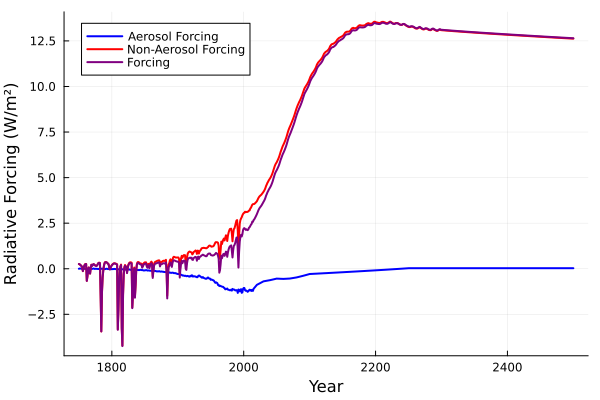

In [11]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)
plot!(p_forcing, t, F, label="Forcing", color=:purple, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

Solution

A function is used to implement the discretized equation:


$$
\begin{align*}
T(t+\Delta t) = T(t) + \frac{\Delta t*(F-\lambda T(t))}{cd}
\end{align*}
$$


Another function is used to run the simulation, using the discretization function for each timestep. The forcing for each timestep is obtained from the forcing vector calculated using the forcing data obtained above.


The Monte Carlo simulation is done by using a for loop to run the simulation for each sample, going up until 2100, and taking the 2100 temperature anomaly. Lambda is selected randomly from the specified distribution for each sample.


The expected value is found to be 4.696 degrees celsius, 0.0638 greater than the estimate using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$. I found that using 10,000 samples led the average to converge, with the running estimate changing little at this point. Furthermore, the 95% confidence interval is fairly small relative to the mean for this number of iterations.

In [12]:
# this function computes the increment by which the concentration
# is updated at each step
function forcing_simulate_timestep(F, λ, c, d,T)
    return ((F-λ*T)/(c*d))
end

# this function loops over the timesteps to simulate
# the concentration series
function climate_simulate(T₀, F, λ, c, d, Δt, times)
    # initialize C storage
    # for code simplicity we make the array length T+1 so
    # index 1 is C₀
    steps = length(times)
    T = zeros(steps)
    T[1] = T₀
    for t = 1:steps-1
        T[t+1] = T[t] + 
            Δt * forcing_simulate_timestep(F[t], λ, c, d,T[t])
    end
    return T
end
times = t
α = 0.8
Δt = 31558152 #s
T₀ = 0 #degrees c
F = forcing_non_aerosol+α*forcing_aerosol
λ = 2.1 #c/(W/m^2)
c = 4.184*10^6 #J/K/m^2
d = 86 #m
T = climate_simulate(T₀, F, λ, c, d, Δt,times)

751-element Vector{Float64}:
 0.0
 0.022731483349329427
 0.040278289494741326
 0.052408265784500536
 0.058950696361573504
 0.06063584224928685
 0.058278631700672184
 0.036311110702349894
 0.03060499874837628
 0.03778068117354878
 ⋮
 6.0349064449781515
 6.033928949865114
 6.032952263810847
 6.031978595303466
 6.0310066214578395
 6.030034177683138
 6.029061472805756
 6.028090703835366
 6.027123866872981

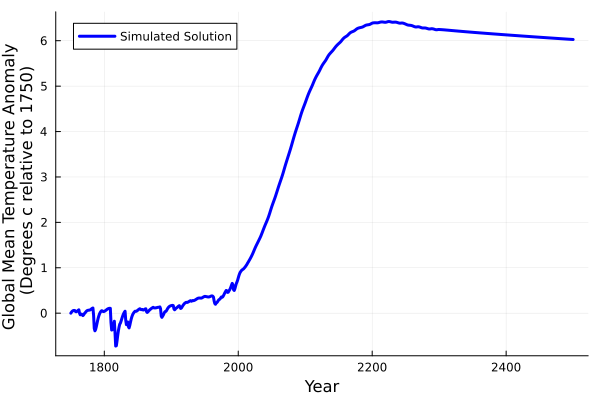

In [13]:
p = plot(; xlabel="Year", ylabel="Global Mean Temperature Anomaly \n (Degrees c relative to 1750)")

# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, times, T, linewidth=3, color=:blue, label="Simulated Solution")

In [14]:
T_2100_baseline = T[isequal.(times, 2100)]

1-element Vector{Float64}:
 4.632496731623587

In [15]:
n_samples = 10000
Random.seed!(1)
lambda_dist = LogNormal(log(2.1),log(2)/4) # can generate any integer between 1 and 6
λ= rand(lambda_dist, n_samples) # simulate rolls
T = zeros(n_samples)
running_estimate= zeros(n_samples)
running_se= zeros(n_samples)

10000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [16]:
n = 1
climate_simulate(T₀, F[isless.(times, 2101)], λ[n], c, d, Δt, times[isless.(times, 2101)])[length(times[isless.(times, 2101)])]

4.68665553637998

In [17]:
for n = 1:n_samples
    T[n] = climate_simulate(T₀, F[isless.(times, 2101)], λ[n], c, d, Δt, times[isless.(times, 2101)])[length(times[isless.(times, 2101)])]
    running_estimate[n] = mean(T[1:n])
    running_se[n] = std(T[1:n])/sqrt(n)
end

In [18]:
running_estimate

10000-element Vector{Float64}:
 4.68665553637998
 4.464880909065896
 4.739176217186418
 4.323441107114527
 4.2226109565633205
 4.257585580212881
 4.144182837519837
 4.289201024624882
 4.423170861324526
 4.469865936624937
 ⋮
 4.696348019152676
 4.696332350859569
 4.696333747374216
 4.696335262991873
 4.696210238774615
 4.696278180489518
 4.696367770976244
 4.696331751544508
 4.696331959179212

In [19]:
running_se[1] = 0

0

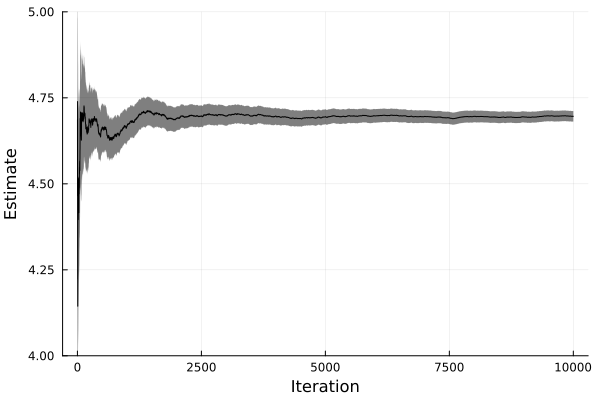

In [20]:
plt = plot(
    running_estimate, ribbon=1.96 * running_se,
    ylim = (4, 5),
    xlabel="Iteration",
    ylabel="Estimate",
    legend = :false,
    color=:black,
    linewidth=1
)

In [21]:
T_2100_baseline[1]

4.632496731623587

In [22]:
T_2100_baseline[1] - 4.696331959179212

-0.0638352275556251

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

## References

List any external references consulted, including classmates.

https://www.geeksforgeeks.org/concatenation-of-arrays-in-julia-cat-vcat-hcat-and-hvcat-methods/ 
https://stackoverflow.com/questions/37474493/location-of-minimum-in-julia

https://github.com/JuliaPlots/StatsPlots.jl/issues/102 

https://stackoverflow.com/questions/55649120/julia-finding-values-larger-than-0-in-vector-with-missing